# Train Tumor classifier on CPC data

Model trained on Camelyon17 data from center 0 and 2 only.

Inference run on training set, as well as on unseen data from center 1, 3 and 4.

In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import pandas as pd
import umap
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import GreedyInfoMax

# 1. Read CPC output from folder

In [4]:
folder = 'E:/OneDrive - Sectra/Research/2020/project_dataembedding/greedyinfomax/experiments/experiment_color_w_domain_center02'

In [8]:
# Read csv files
df_test = pd.read_csv(f'{folder}/training_patches.csv')
df_test_134 = pd.read_csv(f'{folder}/test_patches_subcenter134.csv')

In [6]:
outputs = np.load(f'{folder}/outputs.npy')
outputs_134 = np.load(f'{folder}/outputs_134.npy')

In [9]:
out_array = np.stack(outputs, axis=0)
print(out_array.shape)
print(len(df_test))

(62395, 1024)
62396


In [10]:
# (Compensate for not being able to run last sample)
df_test = df_test.head(-1)
len(df_test)

62395

## Plot points

In [11]:
import umap
# UMAP
reducer = umap.UMAP()
embedding = reducer.fit_transform(out_array)
embedding.shape

e:\.venvs\notebooks-bapbuhj6\lib\site-packages\numba\typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\..\..\.venvs\notebooks-bapbuhj6\lib\site-packages\umap\rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
e:\.venvs\notebooks-bapbuhj6\lib\site-packages\numba\typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\..\..\.venvs\notebooks-bapbuhj6\lib\site-packages\umap\r

(62395, 2)

In [12]:
df_test['x'] = embedding[:, 0]
df_test['y'] = embedding[:, 1]

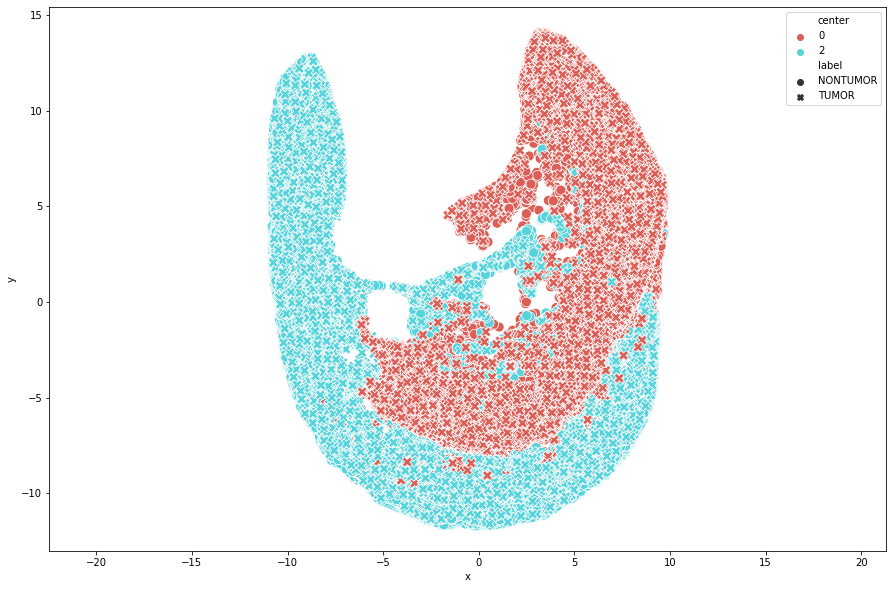

In [15]:
plt.figure(figsize=(15,10))
sns.scatterplot(x='x', y='y', hue='center', style='label', data=df_test, s=100, palette=sns.color_palette("hls", 2))#, legend=None)
g = plt.gca().set_aspect('equal', 'datalim')

# 2. Train classifiers

Train simple NN to classify tumor cells, from CPC output

In [16]:
use_gpu = torch.cuda.is_available()
print("GPU available: ", use_gpu)
device = torch.device('cuda:0')


GPU available:  True


In [17]:
batch_size = 64
learning_rate = 0.01
num_epochs = 10

In [18]:
import random
import numpy as np
from PIL import Image

from torch.utils.data import Dataset

class CPCDataset(Dataset):
    def __init__(self, dataframe, cpc_array):
        self.dataframe = dataframe
        self.cpc_array = cpc_array
        self.label_enum = {'TUMOR': 1, 'NONTUMOR': 0}

    def __len__(self):
        return len(self.dataframe.index)

    def __getitem__(self, index):
        
        row = self.dataframe.iloc[index]
        label = self.label_enum[row.label]
        
        embedding = self.cpc_array[index]
        
        return embedding, label

In [19]:
def NNModel(num_classes) -> nn.Module:
    return nn.Sequential(
            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=num_classes)
        )

In [22]:
def train(model, dataloader, num_epochs, optimizer, criterion):
    for epoch in range(num_epochs):
        model.train(True)
        running_loss = 0.0
        running_corrects = 0.0

        for i, (embedding, label) in enumerate(dataloader):
            batch_loss = 0.0
            batch_corrects = 0.0

            inputs = embedding.to(device).float()
            labels = label.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            if isinstance(outputs, tuple):
                outputs = outputs[0]

            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs.data, 1)

            loss.backward()
            optimizer.step()

            batch_loss = loss.item()
            batch_corrects += torch.sum(preds == labels.data)

            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data)

            # Print output
            print('\r Batch [{}/{}], Train loss: {:.4f}, Acc: {:.4f}'.format(
                i, 
                len(dataloader),
                batch_loss/len(labels),
                batch_corrects/len(labels)
            ), end="")

        #Print per epoch
        print('\n Epoch [{}/{}] Train loss: {:.4f} Acc: {:.4f}'.format(
                        epoch + 1,
                        num_epochs,
                        running_loss/len(dataloader.dataset),
                        running_corrects/len(dataloader.dataset),
                        )
                    )

In [20]:
cpc_dataset = CPCDataset(df_test, out_array.astype(np.float64))

In [21]:
train_loader = DataLoader(cpc_dataset, batch_size, shuffle=True, num_workers=0)

In [56]:
# Model
classifier = NNModel(num_classes=2) # tumor classifier
# Loss function
criterion = nn.CrossEntropyLoss()
# Optimizer, Adam
optimizer = optim.Adam(classifier.parameters(), lr=learning_rate)
classifier.to(device)

train(classifier, train_loader, num_epochs=20, optimizer=optimizer, criterion=criterion)

 Batch [974/975], Train loss: 0.0074, Acc: 0.8305
 Epoch [1/20] Train loss: 0.0068 Acc: 0.8051
 Batch [974/975], Train loss: 0.0069, Acc: 0.8305
 Epoch [2/20] Train loss: 0.0059 Acc: 0.8431
 Batch [974/975], Train loss: 0.0032, Acc: 0.9661
 Epoch [3/20] Train loss: 0.0057 Acc: 0.8505
 Batch [974/975], Train loss: 0.0058, Acc: 0.8644
 Epoch [4/20] Train loss: 0.0056 Acc: 0.8531
 Batch [974/975], Train loss: 0.0070, Acc: 0.8136
 Epoch [5/20] Train loss: 0.0055 Acc: 0.8554
 Batch [974/975], Train loss: 0.0056, Acc: 0.8814
 Epoch [6/20] Train loss: 0.0055 Acc: 0.8566
 Batch [974/975], Train loss: 0.0075, Acc: 0.7797
 Epoch [7/20] Train loss: 0.0054 Acc: 0.8579
 Batch [974/975], Train loss: 0.0073, Acc: 0.8475
 Epoch [8/20] Train loss: 0.0054 Acc: 0.8593
 Batch [974/975], Train loss: 0.0082, Acc: 0.8136
 Epoch [9/20] Train loss: 0.0053 Acc: 0.8616
 Batch [974/975], Train loss: 0.0034, Acc: 0.9153
 Epoch [10/20] Train loss: 0.0053 Acc: 0.8611
 Batch [974/975], Train loss: 0.0059, Acc: 0.8644

# 3. Run inference on test set

In [30]:
def test(model, dataloader):
    model.eval()
    outputs = []
    correct = 0
    df = pd.DataFrame()
    
    with torch.no_grad():
        for batch in dataloader:
            inputs = batch[0].to(device).float()
            labels = batch[1].to(device)
            
            output = model(inputs)
            if isinstance(output, tuple):
                output = output[0]
            
#             test_loss += criterion(output, labels).item()
            preds = torch.argmax(output.data, 1)
            correct += torch.sum(preds == labels.data)
            
            data = {'label': labels.detach().cpu().numpy(), 'prediction': preds.detach().cpu().numpy().squeeze()}
            df = pd.concat([df, pd.DataFrame(data)])
        
        outputs.extend(output.detach().cpu().numpy())
    print(f'\nAccuracy: {correct} / {len(dataloader)*batch_size}')
    print(str(correct.item()/(len(dataloader)*batch_size)*100) + ' %')
    return outputs, df

In [27]:
out_array_134 = np.stack(outputs_134, axis=0).astype(np.float64)

cpc_dataset_134 = CPCDataset(df_test_134, out_array_134)
cpc_test_loader = DataLoader(cpc_dataset_134, batch_size, shuffle=False, num_workers=0)


In [31]:
results_134, df_results = test(classifier, cpc_test_loader)


Accuracy: 20129 / 30016
67.06090085287848 %


In [37]:
results_134[1].sample(10)

,label,prediction
18,1,0
44,0,1
0,1,0
14,0,0
4,1,1
4,1,1
52,1,1
4,0,1
41,0,0
8,1,1


In [43]:
df_test_134['prediction'] = list(results_134[1].prediction)

In [44]:
# UMAP
reducer = umap.UMAP()
embedding = reducer.fit_transform(out_array_134)
embedding.shape

e:\.venvs\notebooks-bapbuhj6\lib\site-packages\numba\typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\..\..\.venvs\notebooks-bapbuhj6\lib\site-packages\umap\nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


(30000, 2)

In [45]:
df_test_134['x'] = embedding[:, 0]
df_test_134['y'] = embedding[:, 1]

In [53]:
def label_to_int(label):
    if label == 'TUMOR': return 1
    if label == 'NONTUMOR': return 0
df_test_134['label_int'] = df_test_134.label.apply(label_to_int)
df_test_134['correct'] = df_test_134.label_int == df_test_134.prediction

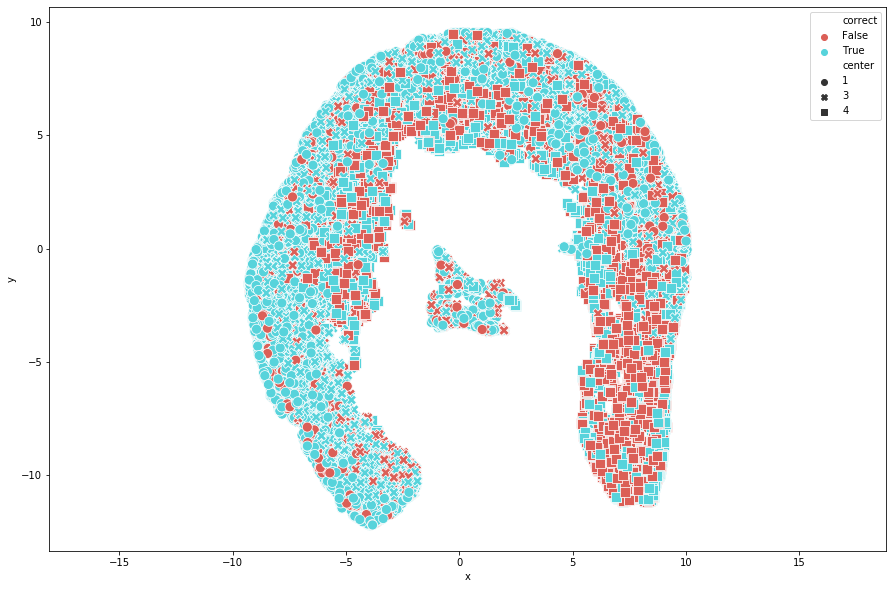

In [54]:
plt.figure(figsize=(15,10))
sns.scatterplot(x='x', y='y', hue='correct', style='center', data=df_test_134, s=100, palette=sns.color_palette("hls", 2))#, legend=None)
g = plt.gca().set_aspect('equal', 'datalim')